In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.model_selection import train_test_split
from collections import Counter

import itertools

from sklearn.metrics import matthews_corrcoef

<h1>Loading Data</h1>

In [2]:
train_path = "/content/drive/MyDrive/Data/Peptide-Analysis/train.dat"
test_path = "/content/drive/MyDrive/Data/Peptide-Analysis/test.dat"
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path,header=None)
train_data.columns = ['String']
train_data = train_data['String'].str.split("\t",n=1 , expand = True )
train_data.columns = ['Class','Peptide']

In [3]:
test_data.head()

0
0         KPTNAYEFGQVLSTISARKDEEACAHL
1  FLTAGDPDLETTRQALLALDREGADLIELGVPYS
2                 RIVQRIKDFLRNLVPRTES
3                     ERWAPARSQAYLGVL
4              FSFEGRRRALQAQEGIAALRDN

<h1>My Bag of Words Function</h1>

In [4]:
dict_val = {}
for i in range(0,len(train_data)):
    for j in train_data['Peptide'][i]:
        if j not in dict_val:
            dict_val[j] = 1
        else:
            dict_val[j] += 1

print(dict_val)

{'K': 2509, 'A': 3160, 'D': 1880, 'E': 2482, 'L': 3582, 'F': 1505, 'N': 1399, 'G': 2726, 'T': 1905, 'V': 2613, 'H': 896, 'W': 503, 'Y': 1063, 'R': 2322, 'C': 575, 'S': 2312, 'M': 752, 'Q': 1359, 'I': 2337, 'P': 1648, 'X': 4}


In [5]:
l1 = []
for i in range(0,len(train_data)):
    dict1 = {'A':0,'B':0,'C':0,'D':0,'E':0,'F':0,'G':0,'H':0,'I':0,'J':0,'K':0,'L':0,'M':0,'N':0,'O':0,'P':0,'Q':0,'R':0,'S':0,'T':0,'U':0,'V':0,'W':0,'X':0,'Y':0,'Z':0}
    for j in train_data['Peptide'][i]:
        if j not in dict1:
            dict1[j] = 1
        else:
            dict1[j] += 1
    
    #dropping X because of low count
    str1=[]
    for k in dict1.values():

            str1.append(int(k))
    l1.append(np.asarray(str1))

In [6]:
train_data['peptide'] = l1
train_data.head(10)

Class  ...                                            peptide
0    -1  ...  [1, 0, 0, 1, 2, 3, 1, 0, 0, 0, 2, 2, 0, 1, 0, ...
1    -1  ...  [6, 0, 1, 2, 0, 6, 4, 2, 0, 0, 1, 6, 2, 1, 0, ...
2    -1  ...  [4, 0, 0, 2, 0, 0, 1, 0, 4, 0, 0, 0, 1, 0, 0, ...
3    -1  ...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 0, 0, 0, ...
4    -1  ...  [2, 0, 1, 0, 2, 1, 5, 1, 0, 0, 1, 3, 0, 1, 0, ...
5    -1  ...  [1, 0, 0, 1, 3, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, ...
6    -1  ...  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...
7    -1  ...  [2, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, ...
8    -1  ...  [2, 0, 0, 1, 0, 2, 3, 2, 1, 0, 1, 2, 1, 2, 0, ...
9     1  ...  [2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 4, 0, 1, 0, ...

[10 rows x 3 columns]

<h1>Analysing Data</h1>

(array([1423.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         142.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

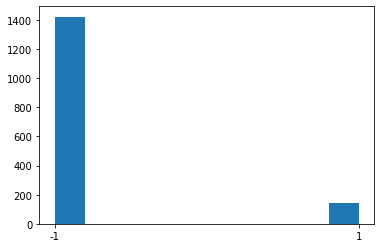

In [7]:
plt.hist(train_data['Class'])

In [8]:
y = train_data['Class']
print(Counter(y))

Counter({'-1': 1423, '1': 142})


<h1>Oversampling 'Class' == 1

In [9]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

X = train_data['peptide']
X = list(X)

y = train_data['Class']
y = y.astype(int)
y = np.where(y < 0, 0, y)

y.reshape(-1,1)

X_ros ,y_ros = ros.fit_resample(X,y)

#print('Original dataset shape', Counter(y))
#print('Resample dataset shape', Counter(y_ros))

In [10]:
print(Counter(y_ros))

Counter({0: 1423, 1: 1423})


Data is now balanced

<h1>Designing Neural Network</h1>

In [11]:
def Sigmoid(Z):
    return 1/(1+np.exp(-Z))

def Relu(Z):
    return np.maximum(0,Z)

def dRelu2(dZ, Z):    
    dZ[Z <= 0] = 0    
    return dZ

def dRelu(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def dSigmoid(Z):
    s = 1/(1+np.exp(-Z))
    dZ = s * (1-s)
    return dZ

class dlnet:
    def __init__(self, x, y):
        self.debug = 0;
        self.X=x
        self.Y=y
        self.Yh=np.zeros((1,self.Y.shape[1])) 
        self.L=2
        self.dims = [9, 15, 1] 
        self.param = {}
        self.ch = {}
        self.grad = {}
        self.loss = []
        self.lr=0.003
        self.sam = self.Y.shape[1]
        self.threshold=0.5
        
    def nInit(self):    
        np.random.seed(1)
        self.param['W1'] = np.random.randn(self.dims[1], self.dims[0]) / np.sqrt(self.dims[0]) 
        self.param['b1'] = np.zeros((self.dims[1], 1))        
        self.param['W2'] = np.random.randn(self.dims[2], self.dims[1]) / np.sqrt(self.dims[1]) 
        self.param['b2'] = np.zeros((self.dims[2], 1))                
        return 

    def forward(self):    
        Z1 = self.param['W1'].dot(self.X) + self.param['b1'] 
        A1 = Relu(Z1)
        self.ch['Z1'],self.ch['A1']=Z1,A1
        
        Z2 = self.param['W2'].dot(A1) + self.param['b2']  
        A2 = Sigmoid(Z2)
        self.ch['Z2'],self.ch['A2']=Z2,A2

        self.Yh=A2
        loss=self.nloss(A2)
        return self.Yh, loss

    def nloss(self,Yh):
        loss = (1./self.sam) * (-np.dot(self.Y,np.log(Yh).T) - np.dot(1-self.Y, np.log(1-Yh).T))    
        return loss

    def backward(self):
        dLoss_Yh = - (np.divide(self.Y, self.Yh ) - np.divide(1 - self.Y, 1 - self.Yh))    
        
        dLoss_Z2 = dLoss_Yh * dSigmoid(self.ch['Z2'])    
        dLoss_A1 = np.dot(self.param["W2"].T,dLoss_Z2)
        dLoss_W2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2,self.ch['A1'].T)
        dLoss_b2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2, np.ones([dLoss_Z2.shape[1],1])) 
                            
        dLoss_Z1 = dLoss_A1 * dRelu(self.ch['Z1'])        
        dLoss_A0 = np.dot(self.param["W1"].T,dLoss_Z1)
        dLoss_W1 = 1./self.X.shape[1] * np.dot(dLoss_Z1,self.X.T)
        dLoss_b1 = 1./self.X.shape[1] * np.dot(dLoss_Z1, np.ones([dLoss_Z1.shape[1],1]))  
        
        self.param["W1"] = self.param["W1"] - self.lr * dLoss_W1
        self.param["b1"] = self.param["b1"] - self.lr * dLoss_b1
        self.param["W2"] = self.param["W2"] - self.lr * dLoss_W2
        self.param["b2"] = self.param["b2"] - self.lr * dLoss_b2
        
        return


    def pred(self,x, y):  
        self.X=x
        self.Y=y
        comp = np.zeros((1,x.shape[1]))
        pred, loss= self.forward()    
    
        for i in range(0, pred.shape[1]):
            if pred[0,i] > self.threshold: comp[0,i] = 1
            else: comp[0,i] = 0
    
        print("Acc: " + str(np.sum((comp == y)/x.shape[1])))
        
        return comp
    
    def gd(self,X, Y, iter = 3000):
        np.random.seed(1)                         
    
        self.nInit()
    
        for i in range(0, iter):
            Yh, loss=self.forward()
            self.backward()
        
            if i % 100 == 0:
                print ("Cost after iteration %i: %f" %(i, loss))
                self.loss.append(loss)

        plt.plot(np.squeeze(self.loss))
        plt.ylabel('Loss')
        plt.xlabel('Iter')
        plt.title("Lr =" + str(self.lr))
        plt.show()
    
        return
    def validgd(self,X, Y, iter = 3000):
        np.random.seed(1)                         
    
        self.nInit()
    
        for i in range(0, iter):
            Yh, loss=self.forward()
            
        
            if i % 100 == 0:
                print ("Cost after iteration %i: %f" %(i, loss))
                self.loss.append(loss)

        plt.plot(np.squeeze(self.loss),"g")
        plt.ylabel('Loss')
        plt.xlabel('Iter')
        plt.title("Lr =" + str(self.lr))
        plt.show()
    
        return
    

#Defining functions for front pass and prediction without loss
    
    def forward_test(self):
        Z1 = self.param['W1'].dot(self.X) + self.param['b1'] 
        A1 = Relu(Z1)
        self.ch['Z1'],self.ch['A1']=Z1,A1
        
        Z2 = self.param['W2'].dot(A1) + self.param['b2']  
        A2 = Sigmoid(Z2)
        self.ch['Z2'],self.ch['A2']=Z2,A2

        self.Yh=A2
        return self.Yh

    def predict_test(self,x):
        self.X=x
        comp = np.zeros((1,x.shape[1]))
        pred = self.forward_test()    
        for i in range(0, pred.shape[1]):
            if pred[0,i] > self.threshold: comp[0,i] = 1
            else: comp[0,i] = 0

        return comp

<h1>Splitiing Data</h1>

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.33, random_state=1)

In [14]:
x_train = np.array(x_train).T
y_train = np.array(y_train)
y_train = np.where(y_train < 0, 0,y_train)
y_train = y_train.reshape(-1,1)

x_test = np.array(x_test).T
y_test = np.array(y_test)
y_test = np.where(y_test < 0, 0,y_test)
y_test = y_test.reshape(-1,1)

print(x_train.shape, y_train.shape,x_test.shape, y_test.shape)

(26, 1906) (1906, 1) (26, 940) (940, 1)


In [15]:
nn = dlnet(x_train,y_train.T)
nn.lr = 0.03
nn.dims = [26, 15, 1] 

Cost after iteration 0: 0.786329
Cost after iteration 100: 0.266225
Cost after iteration 200: 0.213527
Cost after iteration 300: 0.189854
Cost after iteration 400: 0.175963
Cost after iteration 500: 0.166106


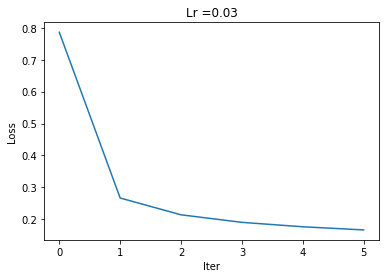

In [16]:
nn.gd(x_train, y_train.T, iter = 600)

In [17]:
pred_train = nn.pred(x_train, y_train.T)

Acc: 0.9233997901364116


In [18]:
from sklearn.metrics import confusion_matrix


In [19]:
def plotCf(a,b,t):
    cf =confusion_matrix(a,b)
    
    plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
    plt.colorbar()
    plt.title(t)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    tick_marks = np.arange(len(set(a))) # length of classes
    class_labels = ['0','1']
    plt.xticks(tick_marks,class_labels)
    plt.yticks(tick_marks,class_labels)
    thresh = cf.max() / 2.
    for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
        plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
    plt.show();

Acc: 0.9233997901364116


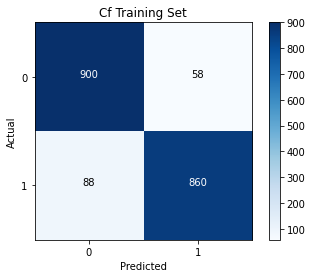

0.8471900871127842


In [20]:
def plot(nn, threshold=0.5):
    nn.threshold=threshold

    nn.X,nn.Y=x_train,y_train 
    target=np.around(np.squeeze(y_train), decimals=0).astype(int)
    predicted=np.around(np.squeeze(nn.pred(x_train,y_train.T)), decimals=0).astype(int)
    plotCf(target,predicted,'Cf Training Set')
    print(matthews_corrcoef(target, predicted))
plot(nn, 0.5)

Acc: 0.9319148936170212


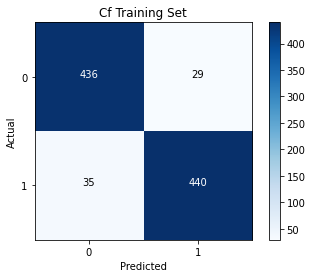

0.8639032640291038


In [21]:
def plot(nn, threshold=0.5):
    nn.threshold=threshold

    nn.X,nn.Y = x_test,y_test 
    target=np.around(np.squeeze(y_test), decimals=0).astype(int)
    predicted=np.around(np.squeeze(nn.pred(x_test,y_test.T)), decimals=0).astype(int)
    plotCf(target,predicted,'Cf Training Set')
    print(matthews_corrcoef(target, predicted))
plot(nn, 0.5)

<h1>Making Predictions</h1>

In [22]:
test_data.columns = ['Peptide']
test_data.head()

Peptide
0         KPTNAYEFGQVLSTISARKDEEACAHL
1  FLTAGDPDLETTRQALLALDREGADLIELGVPYS
2                 RIVQRIKDFLRNLVPRTES
3                     ERWAPARSQAYLGVL
4              FSFEGRRRALQAQEGIAALRDN

In [23]:
dict_val = {'A':0,'B':0,'C':0,'D':0,'E':0,'F':0,'G':0,'H':0,'I':0,'J':0,'K':0,'L':0,'M':0,'N':0,'O':0,'P':0,'Q':0,'R':0,'S':0,'T':0,'U':0,'V':0,'W':0,'X':0,'Y':0,'Z':0}
for i in range(0,len(test_data)):
    for j in test_data['Peptide'][i]:
        if j not in dict_val:
            dict_val[j] = 1
        else:
            dict_val[j] += 1

print(dict_val)

{'A': 695, 'B': 1, 'C': 115, 'D': 481, 'E': 625, 'F': 373, 'G': 672, 'H': 235, 'I': 601, 'J': 0, 'K': 629, 'L': 913, 'M': 192, 'N': 389, 'O': 0, 'P': 409, 'Q': 358, 'R': 713, 'S': 571, 'T': 456, 'U': 0, 'V': 651, 'W': 140, 'X': 0, 'Y': 285, 'Z': 3}


In [24]:
l3 = []
for i in range(0,len(test_data)):
    dict2 = {'A':0,'B':0,'C':0,'D':0,'E':0,'F':0,'G':0,'H':0,'I':0,'J':0,'K':0,'L':0,'M':0,'N':0,'O':0,'P':0,'Q':0,'R':0,'S':0,'T':0,'U':0,'V':0,'W':0,'X':0,'Y':0,'Z':0}
    for j in test_data['Peptide'][i]:
        if j not in dict2:
            dict2[j] = 1
        else:
            dict2[j] += 1
    str1=[]
    for k in dict2.values():

            str1.append(int(k))
    l3.append(np.asarray(str1))

In [25]:
test_data['peptide'] = l3
test_data.head(10)

Peptide                                            peptide
0                 KPTNAYEFGQVLSTISARKDEEACAHL  [4, 0, 1, 1, 3, 1, 1, 1, 1, 0, 2, 2, 0, 1, 0, ...
1          FLTAGDPDLETTRQALLALDREGADLIELGVPYS  [4, 0, 0, 4, 3, 1, 3, 0, 1, 0, 0, 7, 0, 0, 0, ...
2                         RIVQRIKDFLRNLVPRTES  [0, 0, 0, 1, 1, 1, 0, 0, 2, 0, 1, 2, 0, 1, 0, ...
3                             ERWAPARSQAYLGVL  [3, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, ...
4                      FSFEGRRRALQAQEGIAALRDN  [4, 0, 0, 1, 2, 2, 2, 0, 1, 0, 0, 2, 0, 1, 0, ...
5                              LKAFDHRILDQSTG  [1, 0, 0, 2, 0, 1, 1, 1, 1, 0, 1, 2, 0, 0, 0, ...
6                  GRFKRFRKKFKKLFKKLSPVIPLLHL  [0, 0, 0, 0, 0, 4, 1, 1, 1, 0, 7, 5, 0, 0, 0, ...
7  LLANYISGIIEPIQSRVVMIRFNPLPKEAVISRLRYIAENEG  [3, 0, 0, 0, 4, 1, 2, 0, 7, 0, 1, 4, 1, 3, 0, ...
8                                     SLVRTAL  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, ...
9                     TFFRLFNRSGGGFKKFWKWFRRF  [0, 0, 0, 0, 0, 7, 3, 0, 0, 0, 3, 1, 0, 1, 0, ...

In [26]:
test_data.shape

(392, 2)

In [27]:
test_vals = test_data['peptide']
test_vals = np.array(test_vals).T
test_vals.shape

(392,)

In [28]:
a=[]
x = pd.DataFrame()
for i in test_vals:
    
    x= pd.concat([x,pd.DataFrame(i).T])


In [29]:
x.values

array([[4, 0, 1, ..., 0, 1, 0],
       [4, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [7, 0, 1, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 1, 0],
       [4, 0, 1, ..., 0, 0, 0]])

In [30]:
yh = nn.predict_test(x.values.T)[0]

In [31]:
yh = np.where(yh == 0, -1, yh)
with open('/content/drive/MyDrive/Colab Notebooks/result1.txt','w+') as file:
    for i in yh:
        file.write("%s\n" % int(i))

In [33]:
yh.shape

(392,)